# Implementación ambulancias en AR-MDP con SAVIA+



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

# Configuración de reproducibilidad
np.random.seed(42)

# Estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports cargados correctamente")

Imports cargados correctamente


## Configuración del Entorno

In [2]:
@dataclass
class EnvConfig:
    """
    Configuración del entorno de ambulancias.
    """
    # Recursos 
    N_A: int = 12  # Número de ambulancias ALS
    N_B: int = 12  # Número de ambulancias BLS
    
    # Tasa de servicio
    mu: float = 1.2  # tiempo promedio de 50 minutos
    
    # Llegadas por zona 
    lambda_A: np.ndarray = None  # Alta severidad [z1, z2, z3]
    lambda_B: np.ndarray = None  # Baja severidad [z1, z2, z3]
    
    # Señal de necesidad 
    omega_A: float = 0.85  # P(real A | señal A)
    omega_B: float = 0.10  # P(necesita ALS | señal B)
    
    # Utilidades 
    U_aA: float = 1.00  # Paciente A con ALS
    U_aB: float = 0.85  # Paciente A con BLS
    U_bA: float = 0.98  # Paciente B con ALS
    U_bB: float = 1.00  # Paciente B con BLS
    
    # Cobertura base por zona 
    rho_A: np.ndarray = None  # ALS [z1, z2, z3]
    rho_B: np.ndarray = None  # BLS [z1, z2, z3]
    M: int = 5  # Saturación para cobertura
    
    # Uniformización - poissonización
    use_unit_uniformization: bool = False
    
    def __post_init__(self):
        """Construcción lambdas, rhos y cálculos derivados."""
        if self.lambda_A is None:
            self.lambda_A = np.array([0.3, 0.2, 0.15])
        if self.lambda_B is None:
            self.lambda_B = np.array([0.6, 0.4, 0.25])
        if self.rho_A is None:
            self.rho_A = np.array([0.8, 0.6, 0.5])
        if self.rho_B is None:
            self.rho_B = np.array([0.75, 0.65, 0.55])
        
        # Calcular tasa total de llegadas 
        self.lambda_tot = np.sum(self.lambda_A) + np.sum(self.lambda_B)
        
        # Calcular tasa de uniformización 
        if self.use_unit_uniformization:
            self.Lambda = 1.0
        else:
            self.Lambda = self.lambda_tot + self.mu * (self.N_A + self.N_B)
        
        # Número de zonas
        self.n_zones = len(self.lambda_A)
        
        # Espacio de estados
        self.state_space_size = (self.N_A + 1) * (self.N_B + 1)
        
        # Espacio de acciones
        self.actions = ['ALS', 'BLS', 'NOOP']
        self.action_space_size = len(self.actions)

# Crear configuración
config = EnvConfig()

print("=" * 60)
print("CONFIGURACIÓN DEL ENTORNO")
print("=" * 60)
print(f"Ambulancias ALS: {config.N_A}")
print(f"Ambulancias BLS: {config.N_B}")
print(f"Espacio de estados |S|: {config.state_space_size}")
print(f"Espacio de acciones |A|: {config.action_space_size}")
print(f"λ_tot (llegadas totales): {config.lambda_tot:.2f} h⁻¹")
print(f"Λ (uniformización): {config.Lambda:.2f} h⁻¹")
print(f"Tasa de servicio: {config.mu:.2f} h⁻¹")
print(f"Número de zonas: {config.n_zones}")
print("Utilidades:")
print(f"  U_aA: {config.U_aA}, U_aB: {config.U_aB}")
print(f"  U_bA: {config.U_bA}, U_bB: {config.U_bB}")    
print("=" * 60)

CONFIGURACIÓN DEL ENTORNO
Ambulancias ALS: 12
Ambulancias BLS: 12
Espacio de estados |S|: 169
Espacio de acciones |A|: 3
λ_tot (llegadas totales): 1.90 h⁻¹
Λ (uniformización): 30.70 h⁻¹
Tasa de servicio: 1.20 h⁻¹
Número de zonas: 3
Utilidades:
  U_aA: 1.0, U_aB: 0.85
  U_bA: 0.98, U_bB: 1.0


## Clase del Entorno de Ambulancias

In [3]:
class AmbulanceEnvironment:
    """
    Entorno para despacho dinámico de ambulancias.
    """
    
    def __init__(self, config: EnvConfig):
        self.config = config
        
        # Inicializar estado
        self.state = None
        self.reset()
        
        # Crear mapeo de estados a índices
        self._create_state_mappings()
        
        print(f"Entorno inicializado con {self.config.state_space_size} estados")
    
    def _create_state_mappings(self):
        """Crea mapeo bidireccional entre estados y índices"""
        self.state_to_idx = {}
        self.idx_to_state = {}
        
        idx = 0
        for s_A in range(self.config.N_A + 1):
            for s_B in range(self.config.N_B + 1):
                self.state_to_idx[(s_A, s_B)] = idx
                self.idx_to_state[idx] = (s_A, s_B)
                idx += 1
    
    def reset(self) -> Tuple[int, int]:
        """Reinicia el entorno al estado inicial (todos libres)"""
        self.state = (self.config.N_A, self.config.N_B)
        return self.state
    
    def coverage_function(self, ambulance_type: str, zone: int, s_q: int) -> float:
        """
        Función de cobertura
        
        f_q(j, s_q) = 1 - (1 - rho_qj)^min(s_q, M)
        
        """
        if ambulance_type == 'ALS':
            rho = self.config.rho_A[zone]
        else:  # BLS
            rho = self.config.rho_B[zone]
        
        # Aplicar saturación
        effective_units = min(s_q, self.config.M)
        
        # Ecuación de coverage f_q(j, s_q) = 1 - (1 - rho_qj)^min(s_q, M)
        coverage = 1.0 - (1.0 - rho) ** effective_units
        
        return coverage
    
    def expected_reward(self, state: Tuple[int, int], action: str, 
                       call_class: str, zone: int) -> float:
        """
        Recompensa esperada por tomar una acción dado el estado y la llamada.
        """
        if action == 'NOOP':
            return 0.0
        
        s_A, s_B = state
        
        # Verificar disponibilidad
        if action == 'ALS' and s_A == 0:
            return 0.0
        if action == 'BLS' and s_B == 0:
            return 0.0
        
        # Determinar tipo de ambulancia
        ambulance_type = action
        s_q = s_A if action == 'ALS' else s_B
        
        # Probabilidad de cobertura
        coverage = self.coverage_function(ambulance_type, zone, s_q)
        
        # Calcular utilidad esperada según señal observada
        if call_class == 'A':  # Señal indica alta severidad
            omega = self.config.omega_A
            # Con prob omega es realmente A, con prob (1-omega) es B
            if action == 'ALS':
                U_correct = self.config.U_aA  # Paciente A con ALS
                U_incorrect = self.config.U_bA  # Paciente B con ALS
            else:  # BLS
                U_correct = self.config.U_aB  # Paciente A con BLS
                U_incorrect = self.config.U_bB  # Paciente B con BLS
        
        else:  # call_class == 'B': Señal indica baja severidad
            omega = self.config.omega_B
            # Con prob omega necesita ALS, con prob (1-omega) está bien con BLS
            if action == 'ALS':
                U_correct = self.config.U_aA  # Realmente necesita ALS
                U_incorrect = self.config.U_bA  # No necesitaba ALS
            else:  # BLS
                U_correct = self.config.U_aB  # Necesitaba ALS pero recibe BLS
                U_incorrect = self.config.U_bB  # BLS es suficiente
        
        # Recompensa esperada
        expected_utility = omega * U_correct + (1 - omega) * U_incorrect
        expected_reward = expected_utility * coverage
        
        return expected_reward
    
    def event_probabilities(self, state: Tuple[int, int]) -> Dict[str, float]:
        """
        Probabilidades de cada evento. 
        """
        s_A, s_B = state
        
        # Número de ambulancias ocupadas
        busy_A = self.config.N_A - s_A
        busy_B = self.config.N_B - s_B
        
        
        p_arrival = self.config.lambda_tot / self.config.Lambda
        p_ALS_done = (self.config.mu * busy_A) / self.config.Lambda
        p_BLS_done = (self.config.mu * busy_B) / self.config.Lambda
        p_NOOP = 1.0 - (p_arrival + p_ALS_done + p_BLS_done)
        
        return {
            'ARRIVAL': p_arrival,
            'ALS_DONE': p_ALS_done,
            'BLS_DONE': p_BLS_done,
            'NOOP': p_NOOP
        }
    
    def sample_call(self) -> Tuple[str, int]:
        """
        Muestrea una llamada según las tasas de llegada.
        
        Returns:
            (call_class, zone): clase de severidad observada y zona
        """
        # Probabilidades conjuntas
        lambda_all = np.concatenate([self.config.lambda_A, self.config.lambda_B])
        probs = lambda_all / self.config.lambda_tot
        
        # Muestrear
        idx = np.random.choice(6, p=probs)
        
        if idx < 3:
            call_class = 'A'
            zone = idx
        else:
            call_class = 'B'
            zone = idx - 3
        
        return call_class, zone
    
    def step(self, action: str) -> Tuple[Tuple[int, int], float, Dict]:
        """
        Ejecuta un paso en el entorno.
        
        Args:
            action: 'ALS', 'BLS', o 'NOOP'
        
        Returns:
            (next_state, reward, info)
        """
        s_A, s_B = self.state
        
        # Muestrear tipo de evento
        event_probs = self.event_probabilities(self.state)
        event = np.random.choice(
            list(event_probs.keys()),
            p=list(event_probs.values())
        )
        
        reward = 0.0
        info = {'event': event}
        
        if event == 'ARRIVAL':
            # Llega una llamada
            call_class, zone = self.sample_call()
            info['call_class'] = call_class
            info['zone'] = zone
            
            # Calcular recompensa
            reward = self.expected_reward(self.state, action, call_class, zone)
            
            # Transición de estado
            if action == 'ALS' and s_A > 0:
                self.state = (s_A - 1, s_B)
            elif action == 'BLS' and s_B > 0:
                self.state = (s_A, s_B - 1)
            # Si NOOP o no hay disponibilidad, estado no cambia
        
        elif event == 'ALS_DONE':
            # Termina servicio ALS
            if s_A < self.config.N_A:
                self.state = (s_A + 1, s_B)
        
        elif event == 'BLS_DONE':
            # Termina servicio BLS
            if s_B < self.config.N_B:
                self.state = (s_A, s_B + 1)
        
        # NOOP: no pasa nada
        
        return self.state, reward, info

# Crear instancia del entorno
env = AmbulanceEnvironment(config)

print("\n" + "=" * 60)
print(" ENTORNO DE AMBULANCIAS CREADO")
print("=" * 60)

Entorno inicializado con 169 estados

 ENTORNO DE AMBULANCIAS CREADO


## Verificación del Entorno

In [4]:
print("VERIFICACIÓN DEL ENTORNO\n")

# Test 1: Función de cobertura
print("Test 1: Función de Cobertura")
print("-" * 40)
for amb_type in ['ALS', 'BLS']:
    print(f"\n{amb_type}:")
    for zone in range(3):
        for units in [0, 1, 3, 5, 10]:
            cov = env.coverage_function(amb_type, zone, units)
            print(f"  Zona {zone+1}, {units} unidades: {cov:.4f}")

# Test 2: Recompensas esperadas
print("\n\n Test 2: Recompensas Esperadas")
print("-" * 40)
state = (4, 6)  # Todas libres
for call_class in ['A', 'B']:
    for action in ['ALS', 'BLS']:
        for zone in range(3):
            reward = env.expected_reward(state, action, call_class, zone)
            print(f"Clase {call_class}, Acción {action}, Zona {zone+1}: {reward:.4f}")

# Test 3: Probabilidades de eventos
print("\n\n Test 3: Probabilidades de Eventos")
print("-" * 40)
for state in [(4, 6), (2, 3), (0, 0)]:
    print(f"\nEstado {state}:")
    probs = env.event_probabilities(state)
    for event, prob in probs.items():
        print(f"  {event}: {prob:.4f}")
    print(f"  Suma: {sum(probs.values()):.4f}")

# Test 4: Simulación corta
print("\n\n Test 4: Simulación de 10 pasos")
print("-" * 40)
env.reset()
total_reward = 0
for i in range(10):
    # Política aleatoria simple
    action = np.random.choice(['ALS', 'BLS', 'NOOP'])
    next_state, reward, info = env.step(action)
    total_reward += reward
    print(f"Paso {i+1}: s={env.state}, a={action}, r={reward:.3f}, evento={info['event']}")

print(f"\nRecompensa total: {total_reward:.4f}")
print(f"Recompensa promedio: {total_reward/10:.4f}")

print("\n Entorno verificado correctamente")

VERIFICACIÓN DEL ENTORNO

Test 1: Función de Cobertura
----------------------------------------

ALS:
  Zona 1, 0 unidades: 0.0000
  Zona 1, 1 unidades: 0.8000
  Zona 1, 3 unidades: 0.9920
  Zona 1, 5 unidades: 0.9997
  Zona 1, 10 unidades: 0.9997
  Zona 2, 0 unidades: 0.0000
  Zona 2, 1 unidades: 0.6000
  Zona 2, 3 unidades: 0.9360
  Zona 2, 5 unidades: 0.9898
  Zona 2, 10 unidades: 0.9898
  Zona 3, 0 unidades: 0.0000
  Zona 3, 1 unidades: 0.5000
  Zona 3, 3 unidades: 0.8750
  Zona 3, 5 unidades: 0.9688
  Zona 3, 10 unidades: 0.9688

BLS:
  Zona 1, 0 unidades: 0.0000
  Zona 1, 1 unidades: 0.7500
  Zona 1, 3 unidades: 0.9844
  Zona 1, 5 unidades: 0.9990
  Zona 1, 10 unidades: 0.9990
  Zona 2, 0 unidades: 0.0000
  Zona 2, 1 unidades: 0.6500
  Zona 2, 3 unidades: 0.9571
  Zona 2, 5 unidades: 0.9947
  Zona 2, 10 unidades: 0.9947
  Zona 3, 0 unidades: 0.0000
  Zona 3, 1 unidades: 0.5500
  Zona 3, 3 unidades: 0.9089
  Zona 3, 5 unidades: 0.9815
  Zona 3, 10 unidades: 0.9815


 Test 2: Recom

## Funciones Auxiliares

In [5]:
def span_norm(Q):
    """
    Cálculo de la seminorma span. 
    """
    return np.max(Q) - np.min(Q)

def max_action(Q, env):
    """
    Operador max_A:
    
    h(s) = max_{a\in A} Q(s,a).
    
    """
    n_states = env.config.state_space_size
    n_actions = len(env.config.actions)
    
    h = np.zeros(n_states)
    
    for s_idx in range(n_states):
        h[s_idx] = np.max(Q[s_idx, :])
    
    return h

def greedy_policy(Q, env):
    """
    Extrae política greedy: π(s) \in argmax_a Q(s,a).
    
    """
    n_states = env.config.state_space_size
    policy = {}
    
    for s_idx in range(n_states):
        state = env.idx_to_state[s_idx]
        best_action_idx = np.argmax(Q[s_idx, :])
        policy[state] = best_action_idx
    
    return policy

def policy_to_grid(policy, env):
    """
    Convierte política a formato grilla para visualización.
    
    Filas: s_A (0 a N_A)
    Columnas: s_B (0 a N_B)
    
    Returns:
        grid: array (N_A+1) x (N_B+1) con nombres de acciones
    """
    grid = np.empty((env.config.N_A + 1, env.config.N_B + 1), dtype=object)
    
    for s_A in range(env.config.N_A + 1):
        for s_B in range(env.config.N_B + 1):
            state = (s_A, s_B)
            action_idx = policy[state]
            action_name = env.config.actions[action_idx]
            grid[s_A, s_B] = action_name
    
    return grid

print("Funciones auxiliares definidas")
print(f"   - span_norm(Q)")
print(f"   - max_action(Q, env)")
print(f"   - greedy_policy(Q, env)")
print(f"   - policy_to_grid(policy, env)")

Funciones auxiliares definidas
   - span_norm(Q)
   - max_action(Q, env)
   - greedy_policy(Q, env)
   - policy_to_grid(policy, env)


<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/v7/fy8jcw5s2y3b_6gklfsxb9fm0000gn/T/ipykernel_56344/2032188962.py:8: SyntaxWarning: invalid escape sequence '\i'
  """
/var/folders/v7/fy8jcw5s2y3b_6gklfsxb9fm0000gn/T/ipykernel_56344/2032188962.py:25: SyntaxWarning: invalid escape sequence '\i'
  """


## Función para samplear

In [6]:
def sample_next_state(env, state, action):
    """
    Muestrea el siguiente estado dada una acción.
    Simula un paso del MDP uniformizado.
    
    Args:
        env: entorno de ambulancias
        state: tupla (s_A, s_B)
        action: índice de acción (0=ALS, 1=BLS, 2=NOOP)
    
    Returns:
        next_state: tupla (s_A', s_B')
    """
    s_A, s_B = state
    action_name = env.config.actions[action]
    
    # Obtener probabilidades de eventos
    event_probs = env.event_probabilities(state)
    
    # Samplear tipo de evento
    event = np.random.choice(
        list(event_probs.keys()),
        p=list(event_probs.values())
    )
    
    # Transición según evento
    if event == 'ARRIVAL':
        # Si la acción es despachar y hay disponibilidad
        if action_name == 'ALS' and s_A > 0:
            return (s_A - 1, s_B)
        elif action_name == 'BLS' and s_B > 0:
            return (s_A, s_B - 1)
        else:
            return state  # No hay disponibilidad o NOOP
    
    elif event == 'ALS_DONE':
        if s_A < env.config.N_A:
            return (s_A + 1, s_B)
        else:
            return state
    
    elif event == 'BLS_DONE':
        if s_B < env.config.N_B:
            return (s_A, s_B + 1)
        else:
            return state
    
    else:  # NOOP event
        return state

print("Función sample_next_state definida")

Función sample_next_state definida


## Algoritmo 1 SAMPLE (d,m)

In [7]:
def SAMPLE(d, m, env):
    """
    Algoritmo 1 SAMPLE(d, m)
    """
    n_states = env.config.state_space_size
    n_actions = env.config.action_space_size
    
    # Inicializar D
    D = np.zeros((n_states, n_actions))
    
    # Para cada par (s, a)
    for s_idx in range(n_states):
        state = env.idx_to_state[s_idx]
        
        for a_idx in range(n_actions):
            # Samplear m transiciones
            samples = []
            for j in range(m):
                # s_j ~ P(·|s,a)
                next_state = sample_next_state(env, state, a_idx)
                next_state_idx = env.state_to_idx[next_state]
                
                # Evaluar d en el siguiente estado
                samples.append(d[next_state_idx])
            
            # D(s,a) = promedio de las muestras
            D[s_idx, a_idx] = np.mean(samples)
    
    return D

print("=" * 60)
print("ALGORITMO 1 SAMPLE(d, m) IMPLEMENTADO")
print("=" * 60)

ALGORITMO 1 SAMPLE(d, m) IMPLEMENTADO


## SAVIA

In [9]:
def SAVIA(Q0, n, epsilon, delta, env, verbose=True):
    """
    Algoritmo 2 SAVIA(Q^0, n, ε, δ)
    """
    n_states = env.config.state_space_size
    n_actions = env.config.action_space_size
    
    # Calcular α según el paper
    alpha = np.log(2 * n_states * n_actions * (n + 1) / delta)
    
    if verbose:
        print("=" * 70)
        print(f"EJECUTANDO SAVIA")
        print("=" * 70)
        print(f"Parámetros:")
        print(f"  n (iteraciones): {n}")
        print(f"  ε : {epsilon}")
        print(f"  δ : {delta}")
        print(f"  α = ln(2|S||A|(n+1)/δ): {alpha:.4f}")
        print(f"  |S| = {n_states}, |A| = {n_actions}")
        print("=" * 70)
    
    # Inicialización del algoritmo
    # Crear matriz de recompensas r 
    r = np.zeros((n_states, n_actions))
    for s_idx in range(n_states):
        state = env.idx_to_state[s_idx]
        for a_idx in range(n_actions):
            action = env.config.actions[a_idx]
            # Recompensa esperada sobre todas las zonas y clases de llamadas
            total_r = 0.0
            for zone in range(env.config.n_zones):
                for call_class in ['A', 'B']:
                    # Ponderada por probabilidad de (clase, zona)
                    if call_class == 'A':
                        prob = env.config.lambda_A[zone] / env.config.lambda_tot
                    else:
                        prob = env.config.lambda_B[zone] / env.config.lambda_tot
                    
                    rew = env.expected_reward(state, action, call_class, zone)
                    total_r += prob * rew
            
            r[s_idx, a_idx] = total_r
    
    # T^{-1} = r 
    T_prev = r.copy()
    
    # h^{-1} = 0 
    h_prev = np.zeros(n_states)
    
    # β_0 = 0 
    beta_prev = 0.0
    
    # Parámetros para trackear 
    stats = {
        'samples_per_iteration': [],
        'span_d_k': [],
        'span_Q_k': [],
        'span_T_k': [],
        'bellman_residual_sp': [],
        'bellman_residual_inf': [],
        'm_k_values': []
    }
    
    # Loop principal (líneas 4-12)
    if verbose:
        print("\n Comenzando iteraciones...\n")
        iterator = tqdm(range(n + 1), desc="SAVIA Progress")
    else:
        iterator = range(n + 1)
    
    for k in iterator:
        # β_k = k/(k+2) (secuencia de Halpern)
        beta_k = k / (k + 2) if k > 0 else 0.0
        
        # Q^k = (1 - β_k) Q^0 + β_k T^{k-1} (Anc-VI)
        Q_k = (1 - beta_k) * Q0 + beta_k * T_prev
        
        # h^k = max_A(Q^k) 
        h_k = max_action(Q_k, env)
        
        # d^k = h^k - h^{k-1}
        d_k = h_k - h_prev
        
        # Calcular c_k = 5(k+2) ln²(k+2)
        c_k = 5 * (k + 2) * (np.log(k + 2) ** 2)
        
        # m_k = max{⌈α c_k ||d^k||²_sp / ε²⌉, 1}
        span_d_k = span_norm(d_k)
        m_k = max(int(np.ceil(alpha * c_k * (span_d_k ** 2) / (epsilon ** 2))), 1)
        
        # D^k = SAMPLE(d^k, m_k) 
        D_k = SAMPLE(d_k, m_k, env)
        
        # T^k = T^{k-1} + D^k (RECURSIVE SAMPLING!)
        T_k = T_prev + D_k
        
        # Calcular Bellman residual para trackear
        bellman_res_sp = span_norm(Q_k - T_k)
        bellman_res_inf = np.max(np.abs(Q_k - T_k))
        
        # Guardar estadísticas
        stats['samples_per_iteration'].append(m_k * n_states * n_actions)
        stats['span_d_k'].append(span_d_k)
        stats['span_Q_k'].append(span_norm(Q_k))
        stats['span_T_k'].append(span_norm(T_k))
        stats['bellman_residual_sp'].append(bellman_res_sp)
        stats['bellman_residual_inf'].append(bellman_res_inf)
        stats['m_k_values'].append(m_k)
        
        # Actualizar para siguiente iteración
        T_prev = T_k.copy()
        h_prev = h_k.copy()
        beta_prev = beta_k
        
        # Logging cada cierto número de iteraciones
        if verbose and k % max(1, n // 10) == 0:
            print(f"\nIteración {k}/{n}:")
            print(f"  β_k = {beta_k:.4f}")
            print(f"  ||d^k||_sp = {span_d_k:.6f}")
            print(f"  m_k = {m_k:,}")
            print(f"  Samples esta iter: {m_k * n_states * n_actions:,}")
            print(f"  ||Q^k - T^k||_sp = {bellman_res_sp:.6f}")
    
    # Extraer política greedy (línea 13)
    # π^n(s) ∈ argmax_{a∈A} Q^n(s,a) (∀s ∈ S)
    pi_n = greedy_policy(Q_k, env)
    
    if verbose:
        print("\n" + "=" * 70)
        print("SAVIA COMPLETADO")
        print("=" * 70)
        print(f"Total de samples usados: {sum(stats['samples_per_iteration']):,}")
        print(f"Bellman residual final ||Q^n - T^n||_sp: {stats['bellman_residual_sp'][-1]:.6f}")
        print(f"Span de Q final ||Q^n||_sp: {stats['span_Q_k'][-1]:.6f}")
        print("=" * 70)
    
    return Q_k, T_k, pi_n, stats

print("ALGORITMO 2: SAVIA IMPLEMENTADO")

ALGORITMO 2: SAVIA IMPLEMENTADO


## Test de SAVIA

In [ ]:
print("TESTEANDO ALGORITMO 2: SAVIA\n")
print("=" * 70)

# Configuración del test
n_iterations = 6
epsilon_test = 0.1
delta_test = 0.1

# Q0 inicial (empezar desde cero)
n_states = env.config.state_space_size
n_actions = env.config.action_space_size
Q0_test = np.zeros((n_states, n_actions))

print(f"Configuración del test:")
print(f"  Q0: matriz de ceros ({n_states} × {n_actions})")
print(f"  n: {n_iterations} iteraciones")
print(f"  ε: {epsilon_test}")
print(f"  δ: {delta_test}")
print("\n" + "=" * 70 + "\n")

# Ejecutar SAVIA
Q_final, T_final, policy_final, stats = SAVIA(
    Q0=Q0_test,
    n=n_iterations,
    epsilon=epsilon_test,
    delta=delta_test,
    env=env,
    verbose=True
)

# Mostrar política en formato grilla
print("\n POLÍTICA RESULTANTE (Formato Grilla)")
print("=" * 70)
policy_grid = policy_to_grid(policy_final, env)
print("\n        Ambulancias BLS libres")
print("      ", end="")
for s_B in range(env.config.N_B + 1):
    print(f"  {s_B}  ", end="")
print("\n    +" + "-----" * (env.config.N_B + 1))

for s_A in range(env.config.N_A + 1):
    if s_A == env.config.N_A // 2:
        print(f" ALS ", end="")
    else:
        print(f"     ", end="")
    print(f"{s_A} |", end="")
    for s_B in range(env.config.N_B + 1):
        print(f" {policy_grid[s_A, s_B]:^4}", end="")
    print()

print("\n SAVIA ejecutado correctamente!")

TESTEANDO ALGORITHM 2: SAVIA

Configuración del test:
  Q0: matriz de ceros (169 × 3)
  n: 6 iteraciones
  ε: 0.1
  δ: 0.1


EJECUTANDO SAVIA
Parámetros:
  n (iteraciones): 6
  ε : 0.1
  δ : 0.1
  α = ln(2|S||A|(n+1)/δ): 11.1702
  |S| = 169, |A| = 3

 Comenzando iteraciones...



SAVIA Progress:   0%|          | 0/7 [00:00<?, ?it/s]


Iteración 0/6:
  β_k = 0.0000
  ||d^k||_sp = 0.000000
  m_k = 1
  Samples esta iter: 507
  ||Q^k - T^k||_sp = 0.977293


SAVIA Progress:  29%|██▊       | 2/7 [00:08<00:21,  4.29s/it]


Iteración 1/6:
  β_k = 0.3333
  ||d^k||_sp = 0.325764
  m_k = 2,147
  Samples esta iter: 1,088,529
  ||Q^k - T^k||_sp = 0.774476


SAVIA Progress:  43%|████▎     | 3/7 [00:17<00:24,  6.14s/it]


Iteración 2/6:
  β_k = 0.5000
  ||d^k||_sp = 0.222385
  m_k = 2,124
  Samples esta iter: 1,076,868
  ||Q^k - T^k||_sp = 0.656988


SAVIA Progress:  57%|█████▋    | 4/7 [00:26<00:21,  7.27s/it]


Iteración 3/6:
  β_k = 0.6000
  ||d^k||_sp = 0.174076
  m_k = 2,192
  Samples esta iter: 1,111,344
  ||Q^k - T^k||_sp = 0.571512


SAVIA Progress:  71%|███████▏  | 5/7 [00:35<00:15,  7.75s/it]


Iteración 4/6:
  β_k = 0.6667
  ||d^k||_sp = 0.139709
  m_k = 2,100
  Samples esta iter: 1,064,700
  ||Q^k - T^k||_sp = 0.507526


SAVIA Progress:  86%|████████▌ | 6/7 [00:43<00:07,  7.88s/it]


Iteración 5/6:
  β_k = 0.7143
  ||d^k||_sp = 0.116105
  m_k = 1,996
  Samples esta iter: 1,011,972
  ||Q^k - T^k||_sp = 0.457382


SAVIA Progress: 100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Iteración 6/6:
  β_k = 0.7500
  ||d^k||_sp = 0.098108
  m_k = 1,860
  Samples esta iter: 943,020
  ||Q^k - T^k||_sp = 0.416691

SAVIA COMPLETADO
Total de samples usados: 6,296,940
Bellman residual final ||Q^n - T^n||_sp: 0.416691
Span de Q final ||Q^n||_sp: 1.077510

 POLÍTICA RESULTANTE (Formato Grilla)

        Ambulancias BLS libres
        0    1    2    3    4    5    6    7    8    9    10    11    12  
    +-----------------------------------------------------------------
     0 | BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     1 | ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     2 | ALS  ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     3 | ALS  ALS  ALS  ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     4 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     5 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
 ALS 6 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  AL

## SAVIA+

In [11]:
def SAVIA_PLUS(Q0, epsilon, delta, env, max_iterations=10, verbose=True):
    """
    Algoritmo 3: SAVIA+(Q^0, ε, δ)
    """
    if verbose:
        print("=" * 70)
        print("EJECUTANDO SAVIA+")
        print("=" * 70)
        print(f"Parámetros:")
        print(f"  ε : {epsilon}")
        print(f"  δ : {delta}")
        print(f"  Stopping rule: ||Q - T||_sp ≤ 14ε = {14*epsilon:.6f}") 
        print("=" * 70 + "\n")
    
    def compute_c_i(i):
        return 2 ** (i + 2)
    
    stats_all = {
        'cycles': [],
        'n_i_values': [],
        'delta_i_values': [],
        'total_samples_per_cycle': [],
        'bellman_residual_final': [],
        'converged_at_cycle': None
    }
    
    for i in range(max_iterations):
        n_i = 2 ** i
        c_i = compute_c_i(i)
        delta_i = delta / c_i
        
        if verbose:
            print(f"\n{'='*70}")
            print(f" CICLO {i}: n_{i} = {n_i}, δ_{i} = δ/{c_i} = {delta_i:.6f}")
            print(f"{'='*70}")
        
        Q_ni, T_ni, pi_ni, stats_i = SAVIA(
            Q0=Q0,
            n=n_i,
            epsilon=epsilon,
            delta=delta_i,
            env=env,
            verbose=verbose
        )
        
        bellman_residual = span_norm(Q_ni - T_ni)
        
        stats_all['cycles'].append(i)
        stats_all['n_i_values'].append(n_i)
        stats_all['delta_i_values'].append(delta_i)
        stats_all['total_samples_per_cycle'].append(sum(stats_i['samples_per_iteration']))
        stats_all['bellman_residual_final'].append(bellman_residual)
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"RESULTADO CICLO {i}:")
            print(f"  Bellman residual: {bellman_residual:.6f}")
            print(f"  Stopping rule (14ε): {14*epsilon:.6f}")  
            print(f"  Total samples usado: {sum(stats_i['samples_per_iteration']):,}")
        
        # Stopping rule: until ||Q^{n_i} - T^{n_i}||_sp ≤ 14ε 
        if bellman_residual <= 14 * epsilon:  # Condición 
            stats_all['converged_at_cycle'] = i
            if verbose:
                print(f"\n{'='*70}")
                print(f"CONVERGENCIA ALCANZADA EN CICLO {i}!")
                print(f"  ||Q - T||_sp = {bellman_residual:.6f} ≤ {14*epsilon:.6f}") 
                print(f"{'='*70}")
            
            stats_all['final_cycle_stats'] = stats_i
            return Q_ni, T_ni, pi_ni, stats_all
        
        if verbose:
            print(f" No converge. Continuando al ciclo {i+1}...")
            print(f"{'='*70}")
    
    if verbose:
        print(f"\n ADVERTENCIA: No convergió en {max_iterations} ciclos")
        print(f"   Última residual: {bellman_residual:.6f}")
    
    stats_all['final_cycle_stats'] = stats_i
    return Q_ni, T_ni, pi_ni, stats_all

print("ALGORITMO 3: SAVIA+ IMPLEMENTADO (stopping rule = 14ε)")

ALGORITMO 3: SAVIA+ IMPLEMENTADO (stopping rule = 14ε)


## Ejecución de SAVIA+

In [ ]:
print("EJECUTANDO SAVIA+ - EXPERIMENTO PRINCIPAL\n")
print("=" * 70)

# Configuración
epsilon_final = 0.03  
delta_final = 0.1    
n_states = env.config.state_space_size
n_actions = env.config.action_space_size

# Q0 inicial (matriz de ceros)
Q0_initial = np.zeros((n_states, n_actions))

print(f"Configuración:")
print(f"  Q0: Matriz de ceros ({n_states} × {n_actions})")
print(f"  ε: {epsilon_final}")
print(f"  δ: {delta_final}")
print("=" * 70 + "\n")

# ¡EJECUTAR SAVIA+!
Q_optimal, T_optimal, policy_optimal, stats_savia_plus = SAVIA_PLUS(
    Q0=Q0_initial,
    epsilon=epsilon_final,
    delta=delta_final,
    env=env,
    max_iterations=10,
    verbose=True
)

# Calcular métricas finales
h_star_approx = max_action(Q_optimal, env)
span_h_star = span_norm(h_star_approx)
bellman_residual_final = span_norm(Q_optimal - T_optimal)

print("\n\n" + "=" * 70)
print(" SAVIA+ COMPLETADO - RESULTADOS FINALES")
print("=" * 70)
print(f"Convergió en ciclo: {stats_savia_plus['converged_at_cycle']}")
print(f"Total de ciclos ejecutados: {len(stats_savia_plus['cycles'])}")
print(f"||h*||_sp (aproximado): {span_h_star:.6f}")
print(f"Bellman residual final: {bellman_residual_final:.6f}")
print(f"Total samples acumulados: {sum(stats_savia_plus['total_samples_per_cycle']):,}")
print("=" * 70)

# Tabla resumen de ciclos
print("\n RESUMEN POR CICLO:")
print("-" * 70)
print(f"{'Ciclo':<8} {'n_i':<10} {'δ_i':<12} {'Samples':<15} {'Residual':<12}")
print("-" * 70)
for idx, cycle in enumerate(stats_savia_plus['cycles']):
    n_i = stats_savia_plus['n_i_values'][idx]
    delta_i = stats_savia_plus['delta_i_values'][idx]
    samples = stats_savia_plus['total_samples_per_cycle'][idx]
    residual = stats_savia_plus['bellman_residual_final'][idx]
    print(f"{cycle:<8} {n_i:<10} {delta_i:<12.6f} {samples:<15,} {residual:<12.6f}")
print("-" * 70)

# Política final en formato grilla
print("\n POLÍTICA ÓPTIMA (Formato Grilla):")
print("=" * 70)
policy_grid_final = policy_to_grid(policy_optimal, env)
print("\n        Ambulancias BLS libres")
print("      ", end="")
for s_B in range(env.config.N_B + 1):
    print(f"  {s_B}  ", end="")
print("\n    +" + "-----" * (env.config.N_B + 1))

for s_A in range(env.config.N_A + 1):
    if s_A == env.config.N_A // 2:
        print(f" ALS ", end="")
    else:
        print(f"     ", end="")
    print(f"{s_A} |", end="")
    for s_B in range(env.config.N_B + 1):
        print(f" {policy_grid_final[s_A, s_B]:^4}", end="")
    print()

print("\n" + "=" * 70)

EJECUTANDO SAVIA+ - EXPERIMENTO PRINCIPAL

Configuración:
  Q0: Matriz de ceros (169 × 3)
  ε: 0.03
  δ: 0.1

EJECUTANDO SAVIA+
Parámetros:
  ε : 0.03
  δ : 0.1
  Stopping rule: ||Q - T||_sp ≤ 14ε = 0.420000


 CICLO 0: n_0 = 1, δ_0 = δ/4 = 0.025000
EJECUTANDO SAVIA
Parámetros:
  n (iteraciones): 1
  ε : 0.03
  δ : 0.025
  α = ln(2|S||A|(n+1)/δ): 11.3037
  |S| = 169, |A| = 3

 Comenzando iteraciones...



SAVIA Progress:   0%|          | 0/2 [00:00<?, ?it/s]


Iteración 0/1:
  β_k = 0.0000
  ||d^k||_sp = 0.000000
  m_k = 1
  Samples esta iter: 507
  ||Q^k - T^k||_sp = 0.977293


SAVIA Progress: 100%|██████████| 2/2 [01:37<00:00, 48.54s/it]



Iteración 1/1:
  β_k = 0.3333
  ||d^k||_sp = 0.325764
  m_k = 24,131
  Samples esta iter: 12,234,417
  ||Q^k - T^k||_sp = 0.773482

SAVIA COMPLETADO
Total de samples usados: 12,234,924
Bellman residual final ||Q^n - T^n||_sp: 0.773482
Span de Q final ||Q^n||_sp: 0.325764

RESULTADO CICLO 0:
  Bellman residual: 0.773482
  Stopping rule (14ε): 0.420000
  Total samples usado: 12,234,924
 No converge. Continuando al ciclo 1...

 CICLO 1: n_1 = 2, δ_1 = δ/8 = 0.012500
EJECUTANDO SAVIA
Parámetros:
  n (iteraciones): 2
  ε : 0.03
  δ : 0.0125
  α = ln(2|S||A|(n+1)/δ): 12.4023
  |S| = 169, |A| = 3

 Comenzando iteraciones...



SAVIA Progress:   0%|          | 0/3 [00:00<?, ?it/s]


Iteración 0/2:
  β_k = 0.0000
  ||d^k||_sp = 0.000000
  m_k = 1
  Samples esta iter: 507
  ||Q^k - T^k||_sp = 0.977293


SAVIA Progress:  67%|██████▋   | 2/3 [01:45<00:52, 52.92s/it]


Iteración 1/2:
  β_k = 0.3333
  ||d^k||_sp = 0.325764
  m_k = 26,476
  Samples esta iter: 13,423,332
  ||Q^k - T^k||_sp = 0.773305


SAVIA Progress: 100%|██████████| 3/3 [03:30<00:00, 70.26s/it]



Iteración 2/2:
  β_k = 0.5000
  ||d^k||_sp = 0.223490
  m_k = 26,456
  Samples esta iter: 13,413,192
  ||Q^k - T^k||_sp = 0.656831

SAVIA COMPLETADO
Total de samples usados: 26,837,031
Bellman residual final ||Q^n - T^n||_sp: 0.656831
Span de Q final ||Q^n||_sp: 0.549535

RESULTADO CICLO 1:
  Bellman residual: 0.656831
  Stopping rule (14ε): 0.420000
  Total samples usado: 26,837,031
 No converge. Continuando al ciclo 2...

 CICLO 2: n_2 = 4, δ_2 = δ/16 = 0.006250
EJECUTANDO SAVIA
Parámetros:
  n (iteraciones): 4
  ε : 0.03
  δ : 0.00625
  α = ln(2|S||A|(n+1)/δ): 13.6063
  |S| = 169, |A| = 3

 Comenzando iteraciones...



SAVIA Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Iteración 0/4:
  β_k = 0.0000
  ||d^k||_sp = 0.000000
  m_k = 1
  Samples esta iter: 507
  ||Q^k - T^k||_sp = 0.977293


SAVIA Progress:  40%|████      | 2/5 [01:54<02:51, 57.10s/it]


Iteración 1/4:
  β_k = 0.3333
  ||d^k||_sp = 0.325764
  m_k = 29,046
  Samples esta iter: 14,726,322
  ||Q^k - T^k||_sp = 0.773109


SAVIA Progress:  60%|██████    | 3/5 [03:48<02:41, 80.95s/it]


Iteración 2/4:
  β_k = 0.5000
  ||d^k||_sp = 0.223206
  m_k = 28,951
  Samples esta iter: 14,678,157
  ||Q^k - T^k||_sp = 0.656571


SAVIA Progress:  80%|████████  | 4/5 [05:45<01:34, 94.57s/it]


Iteración 3/4:
  β_k = 0.6000
  ||d^k||_sp = 0.174355
  m_k = 29,762
  Samples esta iter: 15,089,334
  ||Q^k - T^k||_sp = 0.571802


SAVIA Progress: 100%|██████████| 5/5 [07:38<00:00, 91.69s/it] 



Iteración 4/4:
  β_k = 0.6667
  ||d^k||_sp = 0.139977
  m_k = 28,530
  Samples esta iter: 14,464,710
  ||Q^k - T^k||_sp = 0.507993

SAVIA COMPLETADO
Total de samples usados: 58,959,030
Bellman residual final ||Q^n - T^n||_sp: 0.507993
Span de Q final ||Q^n||_sp: 0.863580

RESULTADO CICLO 2:
  Bellman residual: 0.507993
  Stopping rule (14ε): 0.420000
  Total samples usado: 58,959,030
 No converge. Continuando al ciclo 3...

 CICLO 3: n_3 = 8, δ_3 = δ/32 = 0.003125
EJECUTANDO SAVIA
Parámetros:
  n (iteraciones): 8
  ε : 0.03
  δ : 0.003125
  α = ln(2|S||A|(n+1)/δ): 14.8872
  |S| = 169, |A| = 3

 Comenzando iteraciones...



SAVIA Progress:   0%|          | 0/9 [00:00<?, ?it/s]


Iteración 0/8:
  β_k = 0.0000
  ||d^k||_sp = 0.000000
  m_k = 1
  Samples esta iter: 507
  ||Q^k - T^k||_sp = 0.977293


SAVIA Progress:  22%|██▏       | 2/9 [02:05<07:18, 62.60s/it]


Iteración 1/8:
  β_k = 0.3333
  ||d^k||_sp = 0.325764
  m_k = 31,781
  Samples esta iter: 16,112,967
  ||Q^k - T^k||_sp = 0.773172


SAVIA Progress:  33%|███▎      | 3/9 [04:10<08:52, 88.81s/it]


Iteración 2/8:
  β_k = 0.5000
  ||d^k||_sp = 0.223538
  m_k = 31,770
  Samples esta iter: 16,107,390
  ||Q^k - T^k||_sp = 0.657071


SAVIA Progress:  44%|████▍     | 4/9 [06:19<08:39, 103.91s/it]


Iteración 3/8:
  β_k = 0.6000
  ||d^k||_sp = 0.174380
  m_k = 32,573
  Samples esta iter: 16,514,511
  ||Q^k - T^k||_sp = 0.572162


SAVIA Progress:  56%|█████▌    | 5/9 [08:24<07:24, 111.22s/it]


Iteración 4/8:
  β_k = 0.6667
  ||d^k||_sp = 0.140002
  m_k = 31,227
  Samples esta iter: 15,832,089
  ||Q^k - T^k||_sp = 0.508002


SAVIA Progress:  67%|██████▋   | 6/9 [10:23<05:40, 113.56s/it]


Iteración 5/8:
  β_k = 0.7143
  ||d^k||_sp = 0.115938
  m_k = 29,468
  Samples esta iter: 14,940,276
  ||Q^k - T^k||_sp = 0.457324


SAVIA Progress:  78%|███████▊  | 7/9 [12:12<03:44, 112.31s/it]


Iteración 6/8:
  β_k = 0.7500
  ||d^k||_sp = 0.097996
  m_k = 27,476
  Samples esta iter: 13,930,332
  ||Q^k - T^k||_sp = 0.416023


SAVIA Progress:  89%|████████▉ | 8/9 [13:52<01:48, 108.29s/it]


Iteración 7/8:
  β_k = 0.7778
  ||d^k||_sp = 0.083936
  m_k = 25,318
  Samples esta iter: 12,836,226
  ||Q^k - T^k||_sp = 0.381817


SAVIA Progress: 100%|██████████| 9/9 [15:25<00:00, 102.85s/it]


Iteración 8/8:
  β_k = 0.8000
  ||d^k||_sp = 0.073050
  m_k = 23,400
  Samples esta iter: 11,863,800
  ||Q^k - T^k||_sp = 0.352683

SAVIA COMPLETADO
Total de samples usados: 118,138,098
Bellman residual final ||Q^n - T^n||_sp: 0.352683
Span de Q final ||Q^n||_sp: 1.235074

RESULTADO CICLO 3:
  Bellman residual: 0.352683
  Stopping rule (14ε): 0.420000
  Total samples usado: 118,138,098

CONVERGENCIA ALCANZADA EN CICLO 3!
  ||Q - T||_sp = 0.352683 ≤ 0.420000


 SAVIA+ COMPLETADO - RESULTADOS FINALES
Convergió en ciclo: 3
Total de ciclos ejecutados: 4
||h*||_sp (aproximado): 1.234604
Bellman residual final: 0.352683
Total samples acumulados: 216,169,083

 RESUMEN POR CICLO:
----------------------------------------------------------------------
Ciclo    n_i        δ_i          Samples         Residual    
----------------------------------------------------------------------
0        1          0.025000     12,234,924      0.773482    
1        2          0.012500     26,837,031      0.6

## Política completa

In [ ]:
# Visualización completa de la política óptima
print("\n POLÍTICA ÓPTIMA COMPLETA:")
print("=" * 70)
print("\n        Ambulancias BLS libres")
print("      ", end="")
for s_B in range(env.config.N_B + 1):
    print(f"  {s_B}  ", end="")
print("\n    +" + "-----" * (env.config.N_B + 1))

for s_A in range(env.config.N_A + 1):
    if s_A == 2:
        print(f" ALS ", end="")
    else:
        print(f"     ", end="")
    print(f"{s_A} |", end="")
    for s_B in range(env.config.N_B + 1):
        print(f" {policy_grid_final[s_A, s_B]:^4}", end="")
    print()

print("\n" + "=" * 70)


 POLÍTICA ÓPTIMA COMPLETA:

        Ambulancias BLS libres
        0    1    2    3    4    5    6    7    8    9    10    11    12  
    +-----------------------------------------------------------------
     0 | NOOP BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     1 | ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
 ALS 2 | ALS  ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     3 | ALS  ALS  ALS  ALS  ALS  BLS  BLS  BLS  BLS  BLS  BLS  BLS  BLS 
     4 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     5 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     6 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     7 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     8 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     9 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 
     10 | ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS  ALS 

## Evaluación de Política

In [16]:
def evaluate_policy(policy, env, n_steps=100000000, verbose=True):
    """
    Simula la política y calcula el average reward.
    """
    if verbose:
        print("=" * 70)
        print(" SIMULANDO POLÍTICA ÓPTIMA")
        print("=" * 70)
        print(f"Pasos de simulación: {n_steps:,}")
        print("=" * 70 + "\n")
    
    env.reset()
    total_reward = 0.0
    arrivals = 0
    rewards_per_arrival = []
    
    events_count = {
        'ARRIVAL': 0,
        'ALS_DONE': 0,
        'BLS_DONE': 0,
        'NOOP': 0
    }
    
    # Simulación
    if verbose:
        steps_iter = tqdm(range(n_steps), desc="Simulación")
    else:
        steps_iter = range(n_steps)
    
    for step in steps_iter:
        state = env.state
        
        # Obtener acción de la política
        action_idx = policy[state]
        action_name = env.config.actions[action_idx]
        
        # Ejecutar paso
        next_state, reward, info = env.step(action_name)
        
        total_reward += reward
        events_count[info['event']] += 1
        
        if info['event'] == 'ARRIVAL':
            arrivals += 1
            rewards_per_arrival.append(reward)
    
    # Calcular métricas
    avg_reward_per_step = total_reward / n_steps
    avg_reward_per_hour = avg_reward_per_step * env.config.Lambda
    avg_reward_per_arrival = total_reward / max(arrivals, 1)
    
    stats = {
        'total_steps': n_steps,
        'total_reward': total_reward,
        'avg_reward_per_step': avg_reward_per_step,
        'avg_reward_per_hour': avg_reward_per_hour,
        'avg_reward_per_arrival': avg_reward_per_arrival,
        'arrivals': arrivals,
        'events_count': events_count,
        'rewards_per_arrival': rewards_per_arrival
    }
    
    if verbose:
        print("\n" + "=" * 70)
        print(" RESULTADOS DE LA SIMULACIÓN")
        print("=" * 70)
        print(f"Recompensa promedio por paso: {avg_reward_per_step:.6f}")
        print(f"Recompensa promedio por hora: {avg_reward_per_hour:.6f}")
        print("=" * 70)
    
    return stats

# Ejecutar evaluación
print("AVERAGE REWARD\n")
evaluation_stats = evaluate_policy(
    policy=policy_optimal,
    env=env,
    n_steps=10000000,
    verbose=True
)

AVERAGE REWARD

 SIMULANDO POLÍTICA ÓPTIMA
Pasos de simulación: 10,000,000



Simulación: 100%|██████████| 10000000/10000000 [02:03<00:00, 80978.64it/s]


 RESULTADOS DE LA SIMULACIÓN
Recompensa promedio por paso: 0.060444
Recompensa promedio por hora: 1.855621


## Visualizaciones


ANÁLISIS GRÁFICO DE CONVERGENCIA 

 Gráficos guardados como 'savia_convergence_analysis.png'


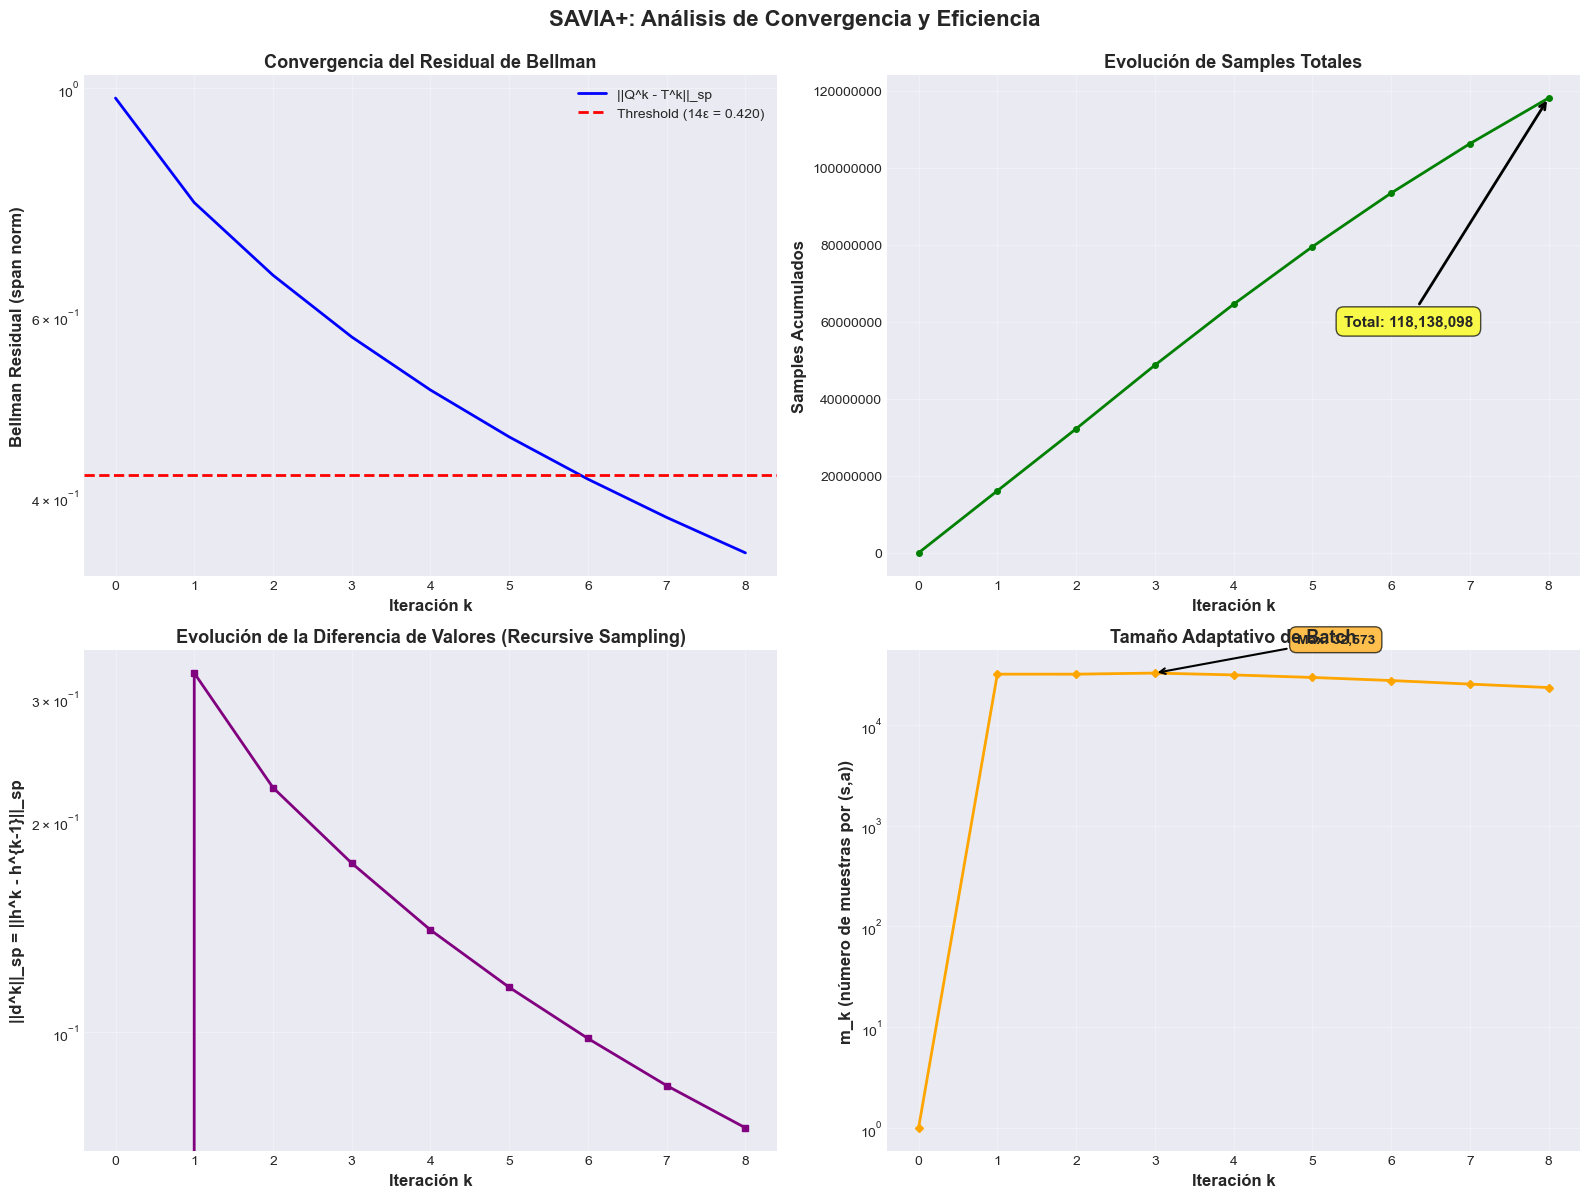

In [17]:
print("\nANÁLISIS GRÁFICO DE CONVERGENCIA \n")

# Obtener stats del ciclo final
final_stats = stats_savia_plus['final_cycle_stats']

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SAVIA+: Análisis de Convergencia y Eficiencia', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================================
# GRÁFICO 1: Bellman Residual vs Iteración
# ============================================================
ax1 = axes[0, 0]
iterations = range(len(final_stats['bellman_residual_sp']))
ax1.plot(iterations, final_stats['bellman_residual_sp'], 
         'b-', linewidth=2, label='||Q^k - T^k||_sp')
ax1.axhline(y=14*epsilon_final, color='r', linestyle='--', 
            linewidth=2, label=f'Threshold (14ε = {14*epsilon_final:.3f})')
ax1.set_xlabel('Iteración k', fontsize=12, fontweight='bold')
ax1.set_ylabel('Bellman Residual (span norm)', fontsize=12, fontweight='bold')
ax1.set_title('Convergencia del Residual de Bellman', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# ============================================================
# GRÁFICO 2: Samples Acumulados vs Iteración
# ============================================================
ax2 = axes[0, 1]
cumulative_samples = np.cumsum(final_stats['samples_per_iteration'])
ax2.plot(iterations, cumulative_samples, 'g-', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Iteración k', fontsize=12, fontweight='bold')
ax2.set_ylabel('Samples Acumulados', fontsize=12, fontweight='bold')
ax2.set_title('Evolución de Samples Totales', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='plain', axis='y')

# Agregar anotación del total
total_samples = cumulative_samples[-1]
ax2.annotate(f'Total: {total_samples:,.0f}', 
             xy=(len(iterations)-1, total_samples),
             xytext=(len(iterations)*0.6, total_samples*0.5),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=2))

# ============================================================
# GRÁFICO 3: ||d^k||_sp vs Iteración
# ============================================================
ax3 = axes[1, 0]
ax3.plot(iterations, final_stats['span_d_k'], 
         'purple', linewidth=2, marker='s', markersize=4)
ax3.set_xlabel('Iteración k', fontsize=12, fontweight='bold')
ax3.set_ylabel('||d^k||_sp = ||h^k - h^{k-1}||_sp', fontsize=12, fontweight='bold')
ax3.set_title('Evolución de la Diferencia de Valores (Recursive Sampling)', 
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# ============================================================
# GRÁFICO 4: Tamaño de Batch m_k vs Iteración
# ============================================================
ax4 = axes[1, 1]
ax4.plot(iterations, final_stats['m_k_values'], 
         'orange', linewidth=2, marker='D', markersize=4)
ax4.set_xlabel('Iteración k', fontsize=12, fontweight='bold')
ax4.set_ylabel('m_k (número de muestras por (s,a))', fontsize=12, fontweight='bold')
ax4.set_title('Tamaño Adaptativo de Batch', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# Agregar anotaciones
max_mk = max(final_stats['m_k_values'])
max_idx = final_stats['m_k_values'].index(max_mk)
ax4.annotate(f'Max: {max_mk:,}', 
             xy=(max_idx, max_mk),
             xytext=(max_idx + len(iterations)*0.2, max_mk*2),
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()
plt.savefig('savia_convergence_analysis.png', dpi=300, bbox_inches='tight')
print(" Gráficos guardados como 'savia_convergence_analysis.png'")
plt.show()